In [1]:
import keras
from keras.layers.core import Layer
import keras.backend as K
import tensorflow as tf

Using TensorFlow backend.


In [2]:
import cv2
import json

import numpy as np
import pandas as pd

from functools import partial
from pathlib import Path 
from tqdm import tqdm



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.applications.inception_v3 import InceptionV3

from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [7]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

[]

In [4]:

# load annotations
df = pd.read_csv("hvc_annotations.csv")
del df["filename"] # remove unwanted column
df.head()

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
2,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg
3,male,Good,45-55,normal-healthy,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/4.jpg
4,female,Good,35-45,slightly-overweight,None,CantSee,Neutral,Front-Frontish,resized/5.jpg


In [5]:
# one hot encoding of labels

one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)

one_hot_df.head().T

,0,1,2,3,4
image_path,resized/1.jpg,resized/2.jpg,resized/3.jpg,resized/4.jpg,resized/5.jpg
gender_female,0,1,0,0,1
gender_male,1,0,1,1,0
imagequality_Average,1,1,0,0,0
imagequality_Bad,0,0,0,0,0
imagequality_Good,0,0,1,1,1
age_15-25,0,0,0,0,0
age_25-35,0,0,0,0,0
age_35-45,1,1,0,0,1
age_45-55,0,0,1,1,0


In [6]:
import keras
import numpy as np

# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

class PersonDataGenerator(keras.utils.Sequence):
    """Ground truth data generator"""

    def __init__(self, df, batch_size=32, shuffle=True, augmentation=None):
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        self.augmentation = augmentation

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
        
        images = np.stack([cv2.imread(item["image_path"]) for _, item in items.iterrows()])

        images = images.astype('float32') / 255
        images_mean = np.mean(images, axis=0)
        images -= images_mean

        if self.augmentation is not None:
            images = self.augmentation.flow(images, shuffle=False).next()
        
        target = {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,
        }
        
        return images, target

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

In [7]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_df, test_size=0.2)
train_df.shape, val_df.shape

((10858, 28), (2715, 28))

In [8]:
train_gen = PersonDataGenerator(train_df, batch_size=32)
valid_gen = PersonDataGenerator(val_df, batch_size=64, shuffle=False)

In [9]:
# get number of output units from data
images, targets = next(iter(train_gen))
num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
num_units

{'gender': 2,
 'image_quality': 3,
 'age': 5,
 'weight': 4,
 'bag': 3,
 'pose': 3,
 'footwear': 3,
 'emotion': 4}

In [10]:
#replacing Inception written in functional api with keras library implementation with weights as zero 
backbone = keras.applications.inception_v3.InceptionV3(
    weights=None, 
    include_top=False, 
    input_tensor=Input(shape=(224, 224, 3))
)

neck = backbone.output
neck = Flatten(name="flatten")(neck)
neck = Dense(512, activation="relu")(neck)


def build_tower(in_layer):
    neck = Dropout(0.2)(in_layer)
    neck = Dense(256,activation='relu')(neck)
    return neck


def build_head(name, in_layer):
    return Dense(
        num_units[name], activation="softmax", name=f"{name}_output"
    )(in_layer)

# heads
gender = build_head("gender", build_tower(neck))
image_quality = build_head("image_quality", build_tower(neck))
age = build_head("age", build_tower(neck))
weight = build_head("weight", build_tower(neck))
bag = build_head("bag", build_tower(neck))
footwear = build_head("footwear", build_tower(neck))
emotion = build_head("emotion", build_tower(neck))
pose = build_head("pose", build_tower(neck))


Dhruv_net = Model(
    inputs=backbone.input, 
    outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

batch_normalization_80 (BatchNo (None, 5, 5, 384)    1152        conv2d_80[0][0]                  
__________________________________________________________________________________________________
batch_normalization_83 (BatchNo (None, 5, 5, 384)    1152        conv2d_83[0][0]                  
__________________________________________________________________________________________________
batch_normalization_84 (BatchNo (None, 5, 5, 384)    1152        conv2d_84[0][0]                  
__________________________________________________________________________________________________
conv2d_85 (Conv2D)              (None, 5, 5, 192)    245760      average_pooling2d_8[0][0]        
__________________________________________________________________________________________________
batch_normalization_77 (BatchNo (None, 5, 5, 320)    960         conv2d_77[0][0]                  
__________________________________________________________________________________________________
activation

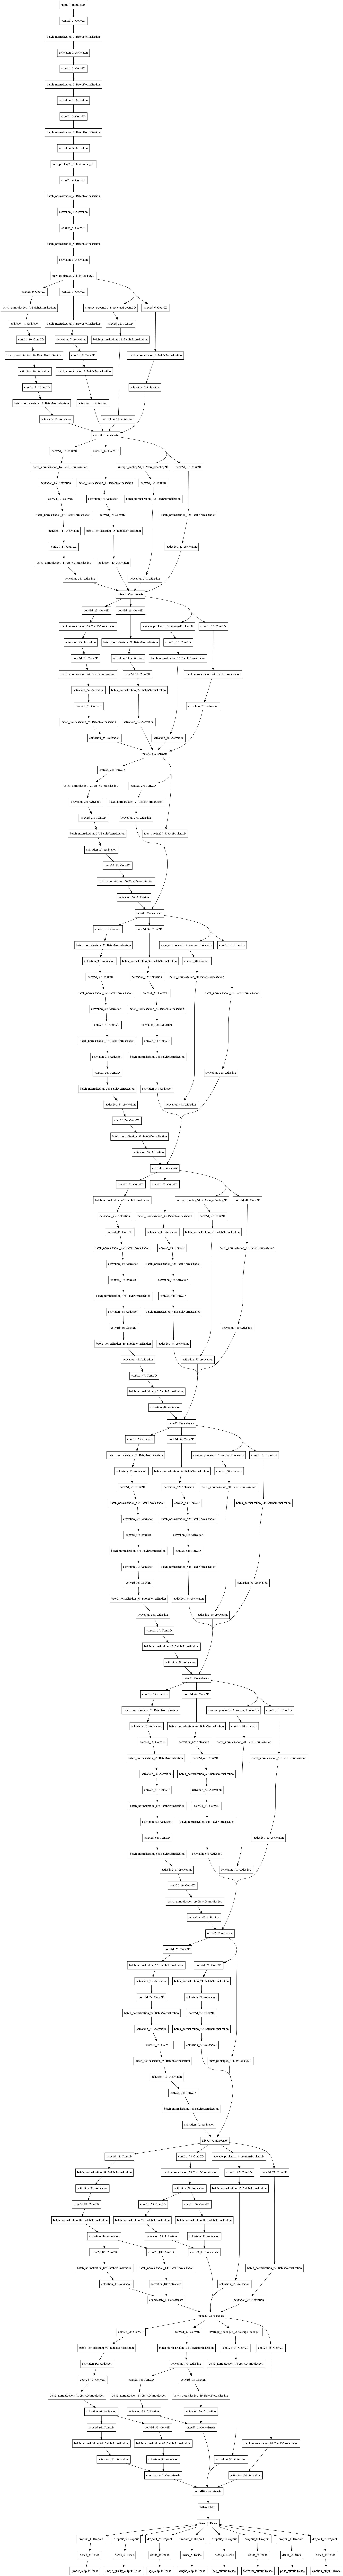

In [12]:
Dhruv_net.summary()
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
# Review model
from keras.utils import plot_model
plot_model(Dhruv_net, to_file='model.png')

In [13]:
class CyclicLR(keras.callbacks.Callback):
    
    def __init__(self,base_lr, max_lr, step_size, base_m, max_m, cyclical_momentum):
 
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.base_m = base_m
        self.max_m = max_m
        self.cyclical_momentum = cyclical_momentum
        self.step_size = step_size
        
        self.clr_iterations = 0.
        self.cm_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}
        
    def clr(self):
        
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        
        if cycle == 2:
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)          
            return self.base_lr-(self.base_lr-self.base_lr/100)*np.maximum(0,(1-x))
        
        else:
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0,(1-x))
    
    def cm(self):
        
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        
        if cycle == 2:
            
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1) 
            return self.max_m
        
        else:
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
            return self.max_m - (self.max_m-self.base_m)*np.maximum(0,(1-x))
        
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())
            
        if self.cyclical_momentum == True:
            if self.clr_iterations == 0:
                K.set_value(self.model.optimizer.momentum, self.cm())
            else:
                K.set_value(self.model.optimizer.momentum, self.cm())
            
            
    def on_batch_begin(self, batch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)
        
        if self.cyclical_momentum == True:
            self.history.setdefault('momentum', []).append(K.get_value(self.model.optimizer.momentum))

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())
        
        if self.cyclical_momentum == True:
            K.set_value(self.model.optimizer.momentum, self.cm())

In [14]:
losses = {
"gender_output": "binary_crossentropy",
"image_quality_output": "categorical_crossentropy",
"age_output": "categorical_crossentropy",
"weight_output": "categorical_crossentropy",
  "bag_output": "categorical_crossentropy",
  "pose_output": "categorical_crossentropy",
  "footwear_output": "categorical_crossentropy",
  "emotion_output": "categorical_crossentropy"

}

loss_weights = {"gender_output": 0.89, "image_quality_output": 1.0, "age_output": 1.0, "weight_output": 0.9, "bag_output": 0.9 ,"pose_output": 1.0,
  "footwear_output": 0.9,
  "emotion_output": 1.0}
 #loss_weights = {"gender_output": 1.0, "image_quality_output": 1.0, "age_output": 1.0}
opt = SGD(lr=0.001, momentum=0.9)
Dhruv_net.compile(
    optimizer=opt,
    loss=losses, 
    loss_weights=loss_weights, 
    metrics=["accuracy"]
)

In [15]:
import sys
# the mock-0.3.1 dir contains testcase.py, testutils.py & mock.py
sys.path.append('D:/Assignment 6/keras_one_cycle_clr-master/keras_one_cycle_clr')
sys.path

['c:\\users\\ddr2kor\\appdata\\local\\programs\\python\\python36\\python36.zip',
 'c:\\users\\ddr2kor\\appdata\\local\\programs\\python\\python36\\DLLs',
 'c:\\users\\ddr2kor\\appdata\\local\\programs\\python\\python36\\lib',
 'c:\\users\\ddr2kor\\appdata\\local\\programs\\python\\python36',
 '',
 'c:\\users\\ddr2kor\\appdata\\local\\programs\\python\\python36\\lib\\site-packages',
 'c:\\users\\ddr2kor\\appdata\\local\\programs\\python\\python36\\lib\\site-packages\\win32',
 'c:\\users\\ddr2kor\\appdata\\local\\programs\\python\\python36\\lib\\site-packages\\win32\\lib',
 'c:\\users\\ddr2kor\\appdata\\local\\programs\\python\\python36\\lib\\site-packages\\Pythonwin',
 'c:\\users\\ddr2kor\\appdata\\local\\programs\\python\\python36\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\ddr2kor\\.ipython',
 'D:/Assignment 6/keras_one_cycle_clr-master/keras_one_cycle_clr']

In [16]:
from lr_range_test import LrRangeTest
from utils import *
from cyclic_lr import *
from one_cycle import *

In [17]:
batch_size=64

In [18]:
epochs = 200
max_lr = 0.001
base_lr = max_lr/100
max_m = 0.98
base_m = 0.85

cyclical_momentum = True
augment = True
cycles = 8

iterations = round(len(train_df)/batch_size*epochs)
iterations = list(range(0,iterations+1))
step_size = len(iterations)/(cycles)


clr =  CyclicLR(base_lr=base_lr,
                max_lr=max_lr,
                step_size=step_size,
                max_m=max_m,
                base_m=base_m,
                cyclical_momentum=cyclical_momentum)

import os
from keras import backend as K
# Prepare model model saving directory.
save_dir = 'D:\Assignment 6\saved_models\\'
model_name = 'Dhruv_Net Inception V3 Faster Convergence.h5' 
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)
print(filepath)


# Prepare callbacks for model saving and for learning rate adjustment.
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath=filepath,
                             #monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

callbacks = [clr, checkpoint]

D:\Assignment 6\saved_models\Dhruv_Net Inception V3 Faster Convergence.h5


In [ ]:
# Run training, with or without data augmentation.
Dhruv_net.fit_generator(
          generator=train_gen,
          validation_data=valid_gen,

          epochs=200,

          #shuffle=True,
          callbacks=callbacks)

Epoch 1/200
339/339 [==============================] - 4242s 13s/step - loss: 7.8809 - gender_output_loss: 0.7148 - image_quality_output_loss: 1.0281 - age_output_loss: 1.5113 - weight_output_loss: 1.0318 - bag_output_loss: 0.9669 - footwear_output_loss: 1.0530 - pose_output_loss: 0.9870 - emotion_output_loss: 0.9718 - gender_output_accuracy: 0.5282 - image_quality_output_accuracy: 0.5289 - age_output_accuracy: 0.3575 - weight_output_accuracy: 0.6162 - bag_output_accuracy: 0.5283 - footwear_output_accuracy: 0.4599 - pose_output_accuracy: 0.5906 - emotion_output_accuracy: 0.6881 - val_loss: 7.2212 - val_gender_output_loss: 0.6859 - val_image_quality_output_loss: 0.9931 - val_age_output_loss: 1.4390 - val_weight_output_loss: 1.0655 - val_bag_output_loss: 0.9417 - val_footwear_output_loss: 1.0078 - val_pose_output_loss: 0.9415 - val_emotion_output_loss: 0.9346 - val_gender_output_accuracy: 0.5763 - val_image_quality_output_accuracy: 0.5506 - val_age_output_accuracy: 0.3958 - val_weight_ou